#### Custom unitary gate approach (14 April)  

Overleaf documentation: https://www.overleaf.com/project/636d711f81310b0cd8b37e65 

New Lindbladian from Kvam paper, with some code adapted from Gunnar's classical open systems simulation

TODO: check that num_states is 4 here? two qubits

This notebook supports the original Lindbladian (Schlimgen group) by changing the make_Lind function; make_Lind_qc is for the cognitive science application model from the Kvam et al. Nature paper. 

#### QuTip tutorials

https://qutip.org/qutip-tutorials/ 

https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html 


#### Code overview
1) Compute Lindbladian operator L

2) Function definitions (measurement, build_propagator, check_unitary, make_circuit)

3) Time evolution calculation

In [33]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.tools.visualization import plot_histogram
from scipy.linalg import expm

#### 1. Simulation constants

In [34]:
#Lindblad equation from 2022 paper (eq. 3)
delta = 1.0   # Default 1, 1, 1
gamma = 1.0  
Omega = 1.0

#### 2. Function definitions

##### 2.1 Lindbladian generation from Kvam et al. Nature paper
$$ \mathcal{L}(\rho) = \sum_{i,j} \gamma_{ij} \left( L_{ij} \bullet \rho \bullet L_{ij}^\dagger - \frac{1}{2} \{ {L_{ij}^\dagger \bullet L_{ij}, \rho}  \} \right) $$

$$ \rho = \sum_j P_j \bullet (\psi_j \bullet \psi_j^\dagger) $$

where $ \gamma_{ij} $ is the parameter that determines the rate of change in the probability of transitioning to preference level i from level j. 
$ p_{j} $ is the probability of being in that pure quantum state. 
$ \gamma_{ij} $ and $ p_{j} $ need to be specified for the Lindbladian calculation. 

##### Function to create the Generator matrix (from Gunnar's code)

In [35]:
def make_gamma(drift, diffusion, num_states):    
    # Convert drift and diffusion to alpha and beta values 
    alpha = diffusion - drift
    beta = diffusion + drift
    
    # Elements on the diagonal
    G_diag = -2*diffusion*np.ones(num_states)
    
    # Element on the upper-diagonal
    G_upper_diag = alpha*np.ones(num_states-1)
    
    # Elements on the lower-diagonal
    G_lower_diag = beta*np.ones(num_states-1)
    
    # Combine them to create the full matrix
    G = np.diag(G_diag) + np.diag(G_upper_diag, 1) + np.diag(G_lower_diag, -1)
    
    # Redefine the two 'corner' elements since the columns of the Generator must sum to 0
    G[0, 0] = -1*beta
    G[num_states-1, num_states-1] = -1*alpha
    return G

# (Classical?) simulation parameters
# num_states = 4 # changed here
# etaM = 25/175    
# driftM/diffusion i.e. drift rate to diffusion rate ratio in Markov component

# Generator matrix creation is called once at:
# G = make_gamma(etaM, 1, num_states)

# gamma_ij values obtained by iterating over num_states and getting G element
# for i in range(num_states):
#    for k in range(num_states):
#        gamma = G[i,k]
#        print("Gamma: ", gamma)

In [36]:
def make_rho(Pj, size):
    """ Makes density matrix rho given input Pj array; psi_j is the pure 
    quantum state of n x 1 column matrix
    Outputs a matrix"""
    assert (size == len(Pj))   # equals n
    result = np.zeros((size, size))  # density matrix output
    for idx in range(size):
        result[idx][idx] = Pj[idx]
    return result

def make_Lij(i,j, size): 
    """ Lij is n x n matrix with a one in i,j and zero otherwise """
    ans = np.zeros((size, size), dtype=int)
    ans[i,j] = 1
    return ans

def make_Lind_qc(gamma, Pj, size):
    """
    Calculates Lindbladian superoperator based on Kvam et al. Temporal Oscillations paper
    Quantum cognition model
    """
    rho = make_rho(Pj, size)
    Lind = np.zeros((4,4))
    for i in range(size):
        for j in range(size):
            # todo: math here
            Lij = np.asmatrix(make_Lij(i,j,size))
            Lij_dagger = Lij.getH()
            # for the conjugate transpose
            
            bracket = Lij @ rho @ Lij_dagger -1/2*((Lij_dagger @ Lij) @ rho + rho @ (Lij_dagger @ Lij))
            Lind += gamma[i][j] * bracket
    return Lind

In [37]:
# debugging testing

# uniform Pj probability distribution
# Pj = []
#for i in range(num_states):
#    Pj.append(1/num_states)   
    
# Pj can also be normal distribution e.g. [0.15, 0.35, 0.35, 0.15]
# Pj = [0.1, 0.4, 0.4, 0.1]
# print("Pj array: ", Pj)

# Lind_qc = make_Lind_qc(G, Pj, len(Pj))
# print("Lind_qc: ", Lind_qc)


##### 2.2 Lindbladian generation from Schlimgen et al. papers

TODO: Check is blackboard I term used to represent the identity matrix or ones(2,2)? (square matrix of all 1's)

In [38]:
def make_Lind(delta, gamma, Omega):
    """
    Calculates Lindbladian superoperator based on chosen parameters
    """
    sigma_z = np.matrix(([1,0],[0,-1]))
    sigma_x = np.matrix(([0,1],[1,0]))
    sigma_ = np.matrix(([0,0],[1,0]))      # changed
    
    # Hamiltonian
    Ham = -delta/2*sigma_z - Omega/2*sigma_x
    Ham_trans = Ham.transpose()
    Ck = np.sqrt(gamma)*sigma_

    # Taking the I as identity instead of ones matrix
#     term1 = -1j*np.kron(np.identity(2), Ham)
#     term2 = 1j*np.kron(Ham_trans, np.identity(2))
#     term3 = np.kron(np.conjugate(Ck), Ck)
#     term4 = -1/2*np.kron(np.identity(2), Ck.getH() @ Ck)
#     term5 = -1/2*np.kron(Ck.transpose() @ np.conjugate(Ck), np.identity(2))
    
    term1 = -1j*np.kron(np.ones((2,2)), Ham)
    term2 = 1j*np.kron(Ham_trans, np.ones((2,2)))
    term3 = np.kron(np.conjugate(Ck), Ck)
    term4 = -1/2*np.kron(np.ones((2,2)), Ck.getH() @ Ck)
    term5 = -1/2*np.kron(Ck.transpose() @ np.conjugate(Ck), np.ones((2,2)))
    
    return term1 + term2 + term3 + term4 + term5

In [39]:
def measurement(Lind, time=0):
    """
    Main function to make circuit and measure
    M in master equation obtained from matrix exponentiation
    Output: counts dictionary e.g. {'0000': 1024}
    """
    M = np.matrix(expm(Lind*time)) 
    U = build_propagator(M)
    U_operator = check_unitary(U)
    #print("Debug: U_operator: \n", U_operator)
    result = make_circuit(U_operator)
    return result

In [40]:
def build_propagator(M, epsilon=0.0001):
    """
    Function to built operator matrix U, based on input M
    See Schlimgen (2021) paper for details eq.13
    Matrix exponentiation using scipy, type cast back to matrix for getH complex conjugation
    """
    # Compute Hermitian (S) and anti-Hermitian (A) matrices
    S = 0.5*(M + M.getH())   # conjugate transpose .getH, Hermitian
    A = 0.5*(M - M.getH())
    
    # Compute eq. 10 of Schmlingen (2022 paper)
    # Matrix exponential function from scipy
    # Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html 
    Sm = np.matrix(1j*expm(-1j*epsilon*S))     
    Sp = (-Sm).getH()
    Am = np.matrix(expm(-epsilon*A))
    Ap = Am.getH()
    
    # Populate U matrix
    dim_M = len(M)   # 2
    U = np.zeros((4*dim_M,4*dim_M),dtype = 'complex_')   # enable complex values

    for i in range(dim_M):
        for j in range(dim_M):
            U[i][j] = Sm.item(i,j)
            U[i+dim_M][j+dim_M] = -Sp.item(i,j)
            U[i+2*dim_M][j+2*dim_M] = -Am.item(i,j)
            U[i+3*dim_M][j+3*dim_M] = Ap.item(i,j)
    
    #print("Propagator U:\n", np.round(U,5))   
    return np.matrix(U)       # cast to matrix 

In [41]:
def check_unitary(U):
    """
    Checker function if matrix is unitary using np.allclose
    Returns U_operator or None 
    """
    U_dg = U.getH()    # compute conjugate transpose
    I = np.identity(len(U_dg))    
    if (np.allclose(I, U@U_dg)):
        #print("Unitary propagator obtained as U_operator.")
        return qi.Operator(U)  # make Qiskit operator
    else:
        print("Error - U is not unitary.")
        return None

In [42]:
def make_circuit(U_operator, qubits_count=4):
    """
    Generates circuit and obtains measurement, using
    custom gate approach
    Example: https://qiskit.org/documentation/tutorials/simulators/4_custom_gate_noise.html 
    Ideal simulator backend and transpile circuit
    """
    circuit = QuantumCircuit(qubits_count,qubits_count)   # 3 qubits, U is 8x8 matrix
    circuit.h(0)
    circuit.h(1)
    circuit.x(2)
    circuit.unitary(U_operator, [0, 1, 2, 3], label='U')
    circuit.h(0)
    circuit.h(1)
    circuit.x(2)
    circuit.measure([0,1,2,3], [0,1,2,3])
    
    #circuit.draw("mpl")    
    tcircuit = transpile(circuit, AerSimulator())
    results = AerSimulator().run(tcircuit).result()    
    return results.get_counts(0)

#### 3. Time evolution

In [43]:
count = 1
results = []
counts = []
MAX_TURNS = 800
TIMESTEP = 0.1
MAXSHOTS = 1024  # quantum circuit

Lind = make_Lind(delta, gamma, Omega)
#Lind = make_Lind_qc(G, Pj, len(Pj))
print("Generated Lindbladian superoperator is:\n", Lind)

while count < MAX_TURNS:
    """
    Do simulation as per paper
    """
    t = 1*count*TIMESTEP
    count += 1
    result = measurement(Lind, t)
    #print("Count:",count,"   ", result)
    results.append(result)
    counts.append(count)

Generated Lindbladian superoperator is:
 [[-1. +0.j -0.5+0.j -0.5+0.j  0. +0.j]
 [-0.5+0.j -0.5-1.j  0. +0.j  0. -1.j]
 [-0.5+0.j  0. +0.j -0.5+1.j  0. +1.j]
 [ 1. +0.j  0. -1.j  0. +1.j  0. +0.j]]


Simulation parameters: delta: 1.0    gamma: 1.0    Omega 1.0


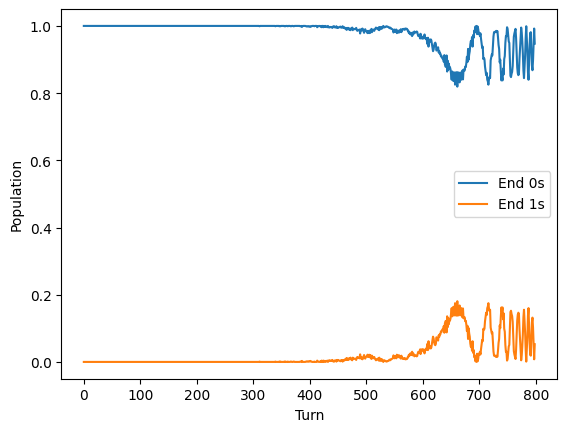

In [44]:
"""
CHANGED THE RESULT ALLOCATION 14/4
Add in the 00, 01 header cases
"""

end_0s = []
end_1s = []

for i in range(MAX_TURNS - 1):
    num_0s = 0
    num_1s = 0
    if results[i].get("0000") != None:    # in case they don't appear
        num_0s += results[i].get("0000")/MAXSHOTS
    if results[i].get("0010") != None:
        num_1s += results[i].get("0010")/MAXSHOTS
    if results[i].get("0001") != None:
        num_0s += results[i].get("0001")/MAXSHOTS
    if results[i].get("0011") != None:
        num_1s += results[i].get("0011")/MAXSHOTS
    end_0s.append(num_0s)
    end_1s.append(num_1s)

print("Simulation parameters: delta:",delta,"   gamma:",gamma,"   Omega",Omega)
    
plt.plot(end_0s, label="End 0s")
plt.plot(end_1s, label="End 1s")
plt.xlabel("Turn")
plt.ylabel("Population")
plt.legend()
plt.show()

#plot_histogram(counts, title='Output')

### Math notes

Any operator M can be decomposed into a Hermitian and anti-Hermitian component.

Definitions - Hermitian: $H^\dagger = H$ ; anti-Hermitian: $H^\dagger = -H$

Unitary matrix: $U^\dagger U = I$

$A = \frac{A + A^\dagger}{2} + \frac{A - A^\dagger}{2} = B + C$

Hermitian:
$B^\dagger = \frac{A^\dagger + A}{2} = B$

Anti-Hermitian:
$C^\dagger = \frac{A^\dagger - A}{2} = -C$

Propagator $U = 
\begin{pmatrix}
S_m & 0 & 0 & 0\\
0 & -S_p & 0 & 0\\
0 & 0 & -A_m & 0\\
0 & 0 & 0 & A_p
\end{pmatrix}
$

#### Useful built-in functions
- matrix.transpose()
- matrix.getH() for conjugate transpose
- np.identity(N)
- matrix.item(i,j) to access (i,j) element of matrix object
- np.allclose(matrix1, matrix2)

### Sample circuit and measurement
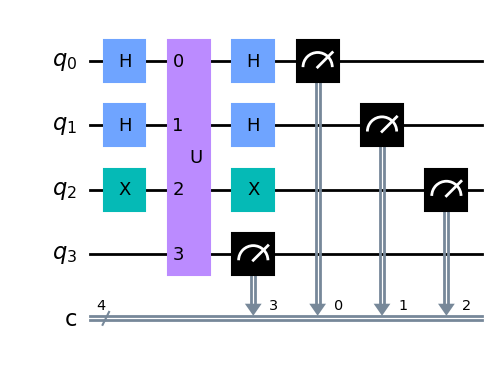

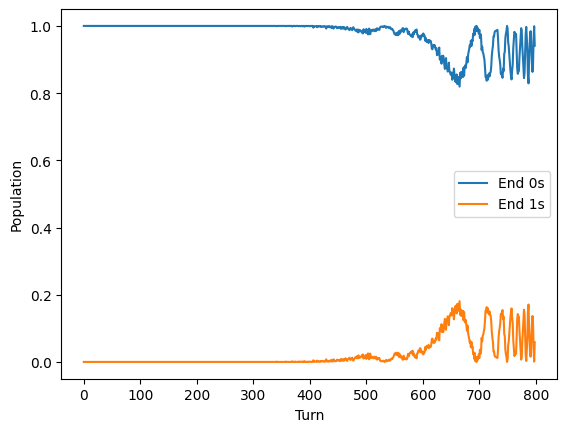

#### 4. Analytical time evolution (by equation)

Implement eq. 4 of "Quantum simulation of the Lindblad equation..."

$ |\rho(t)> = e^{\mathcal{L}t} |\rho(0)> $

\begin{equation} |\rho> = \begin{pmatrix} \rho_{00} \\ \rho_{10} \\ … \\ \rho_{nn} \end{pmatrix} \end{equation}

Diagonal elements of the density matrix represent the probabilities of finding the system in each of its possible states.


==== ANALYTICAL DENSITY MATRIX PROPAGATION ====
Initial rho state vector: 
 [[0.25]
 [0.25]
 [0.25]
 [0.75]]
Lindladian generated is: 
 [[-1. +0.j  -0.5+1.5j -0.5-1.5j  0. +0.j ]
 [-0.5+1.5j -0.5-1.j   0. +0.j   0. -2.5j]
 [-0.5-1.5j  0. +0.j  -0.5+1.j   0. +2.5j]
 [ 1. +0.j   0. -2.5j  0. +2.5j  0. +0.j ]]


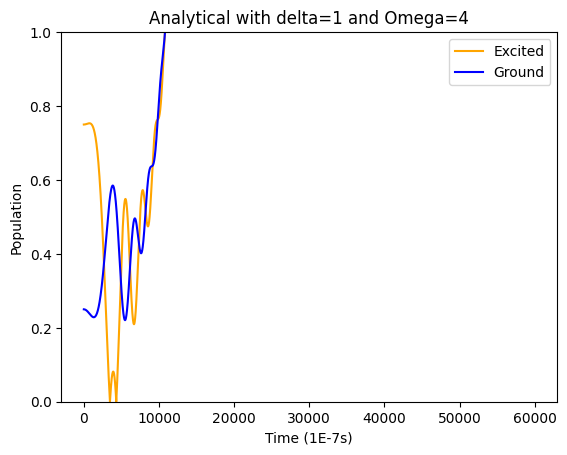

In [45]:
# eq. 14 from other 2021 paper; diagonal elements must add to one
rho_col = np.matrix([[0.25], [0.25], [0.25], [0.75]])
print("==== ANALYTICAL DENSITY MATRIX PROPAGATION ====")
print("Initial rho state vector: \n", rho_col)

# Make a new Lind to ensure correct function; (delta, gamma, Omega)
delta = 1
Omega = 4
Lind = make_Lind(delta, gamma, Omega)
print("Lindladian generated is: \n", Lind)

time_array    = []
ground_array  = []
excited_array = []
for n in range(60000):
    time = n*1E-7
    rho_col = np.matrix(expm(Lind*time))*rho_col
    time_array.append(n)
    
    # remove imaginary numerical part
    ground_array.append(float(np.abs(rho_col[0])))
    excited_array.append(float(np.abs(rho_col[3])))

plt.plot(time_array, excited_array, 'orange', label='Excited')
plt.plot(time_array, ground_array, 'blue', label='Ground')
plt.xlabel("Time (1E-7s)")
plt.ylabel("Population")
plt.ylim(0,1)
plt.legend()
plt.title("Analytical with delta="+str(delta)+" and Omega="+str(Omega))
plt.show()

In [46]:
# end of code
import qiskit.tools.jupyter
%qiskit_version_table

In [47]:
# debugging support
